# Spam Message Classification #


## 1) Data Preprocessing

In [5]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt


In [6]:
spam_df = pd.read_csv('spam.tsv', sep = '\t')

In [7]:
spam_df.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [8]:
#Check whether we have missing records
spam_df.isna().sum()

#isna() will return True where there is a null value. Sum will add up all the Trues.
# A non zero in any column will suggest a missing value was found in that column

label      0
message    0
length     0
punct      0
dtype: int64

In [9]:
spam_df.describe()

,length,punct
count,5572.000000,5572.000000
mean,80.489950,4.177495
std,59.942907,4.623919
min,2.000000,0.000000
25%,36.000000,2.000000
50%,62.000000,3.000000
75%,122.000000,6.000000
max,910.000000,133.000000


In [10]:
#Grab how many records have the 'ham' label and how many have the 'spam' label

spam_df['label'].value_counts()/(len(spam_df))

ham     0.865937
spam    0.134063
Name: label, dtype: float64

From the output of the cell above we can see that the dataset contains an inbalance in the proportion of spam vs ham labels. Thus in extracting data to train a classifier, we need to ensure that our dataset is not biased and contains an equal representation of both classes

In [11]:
#Get a subset of data based on whether it contains the 'ham' label
ham = spam_df[spam_df['label'] == 'ham']

In [12]:
spam = spam_df[spam_df['label'] == 'spam']

In [13]:
# print the shape of the dataset. Both contain 4 columns. But ham has 4825 rows while spam has 747 rows
ham.shape, spam.shape


((4825, 4), (747, 4))

In [14]:
# Get a random sample of n rows from ham where n is the number of rows of spam
ham= ham.sample(spam.shape[0])

In [15]:
#See that ham.shape == spam.shape
ham.shape == spam.shape

True

In [16]:
#Now we can create a new dataset that contains both ham and spam messages

data = ham.append(spam, ignore_index=True)

<ipython-input-16-4682de3dd36e>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = ham.append(spam, ignore_index=True)


In [17]:
data['label'].value_counts()

ham     747
spam    747
Name: label, dtype: int64

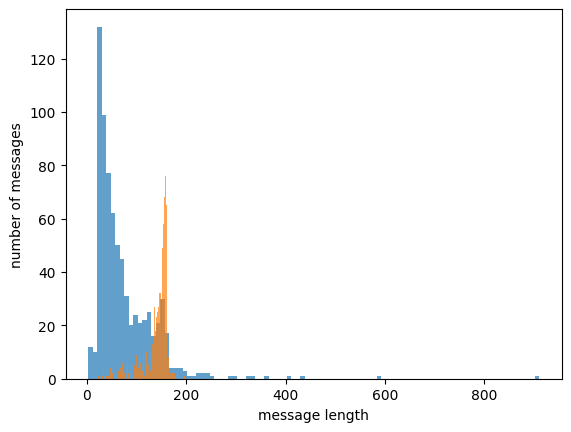

In [18]:
# Lets visualize the data in ham as a histogram so we understand the length of the messages
plt.hist(data[data['label']== 'ham']['length'], bins = 100, alpha = 0.7)
plt.hist(data[data['label']== 'spam']['length'], bins = 100, alpha = 0.7)
plt.xlabel('message length')
plt.ylabel('number of messages')
plt.show()

The data shows that the spam category (organge) tends to be higher length than the ham category

In [19]:
print(data[data['label']=='ham'])

    label                                            message  length  punct
0     ham                           Convey my regards to him      24      0
1     ham  No shit, but I wasn't that surprised, so I wen...     165      4
2     ham                 I'm in a meeting, call me later at      34      2
3     ham  Wow so healthy. Old airport rd lor. Cant thk o...      95      5
4     ham                             Yes, princess. Toledo.      22      3
..    ...                                                ...     ...    ...
742   ham     Probably not, still going over some stuff here      46      1
743   ham  Well obviously not because all the people in m...      79      3
744   ham  I know but you need to get hotel now. I just g...     149      3
745   ham                                                Ok.       3      1
746   ham  But I'm on a diet. And I ate 1 too many slices...      92      5

[747 rows x 4 columns]


## Training the Spam Classification Model

### Split the data into Train and Test

In [20]:
data

,label,message,length,punct
0,ham,Convey my regards to him,24,0
1,ham,"No shit, but I wasn't that surprised, so I wen...",165,4
2,ham,"I'm in a meeting, call me later at",34,2
3,ham,Wow so healthy. Old airport rd lor. Cant thk o...,95,5
4,ham,"Yes, princess. Toledo.",22,3
...,...,...,...,...
1489,spam,Want explicit SEX in 30 secs? Ring 02073162414...,90,3
1490,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,158,5
1491,spam,Had your contract mobile 11 Mnths? Latest Moto...,160,8
1492,spam,REMINDER FROM O2: To get 2.50 pounds free call...,147,3


In [20]:
#Split 30% into test and 70% into train

In [22]:
from sklearn.model_selection import train_test_split
'''
PARAMS:
*arrays : sequence of indexables with same length / shape[0]
    Allowed inputs are lists, numpy arrays, scipy-sparse
matrices or pandas dataframes.

test_size : float or int, default=None
    If float, should be between 0.0 and 1.0 and represent the proportion
of the dataset to include in the test split. If int, represents the
absolute number of test samples. If None, the value is set to the
complement of the train size. If train_size is also None, it will
be set to 0.25.

train_size : float or int, default=None
    If float, should be between 0.0 and 1.0 and represent the
proportion of the dataset to include in the train split. If
int, represents the absolute number of train samples. If None,
the value is automatically set to the complement of the test size.

random_state : int, RandomState instance or None, default=None
    Controls the shuffling applied to the data before applying the split.
Pass an int for reproducible output across multiple function calls.

shuffle : bool, default=True
    Whether or not to shuffle the data before splitting. If shuffle=False
then stratify must be None.
'''

X_train, X_test, y_train, y_test = train_test_split(data['message'], data['label'], test_size =0.3, random_state=0,shuffle= True )

In [26]:
#Print size of the training set
X_train.shape

(1045,)

In [27]:
X_test.shape

(449,)

### Creating our Random Forest Model

We are dealing with text data. We need to convert the text into numbers that the model can process. For this experiment we will learn about Term Frequency Inverse Document Frequency. This tells you the presence of a particular kind of word in a document.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline

#Create a pipeline object (takes a list of tuples defining transformers where the final element in the list is an estimator)
classifier = Pipeline([("tfidf", TfidfVectorizer()),("classifier", RandomForestClassifier(n_estimators=100))])

In [32]:
classifier.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('classifier', RandomForestClassifier())])

## Predicting results (Random Forest)

In [33]:
y_pred = classifier.predict(X_test)


In [35]:
y_test, y_pred

(799     spam
 1047    spam
 1436    spam
 54       ham
 793     spam
         ... 
 824     spam
 822     spam
 644      ham
 1034    spam
 1356    spam
 Name: label, Length: 449, dtype: object,
 array(['spam', 'spam', 'spam', 'ham', 'spam', 'spam', 'ham', 'ham', 'ham',
        'ham', 'spam', 'ham', 'ham', 'spam', 'spam', 'spam', 'spam', 'ham',
        'ham', 'spam', 'spam', 'ham', 'spam', 'spam', 'ham', 'spam', 'ham',
        'ham', 'spam', 'ham', 'ham', 'spam', 'spam', 'spam', 'spam',
        'spam', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham',
        'ham', 'spam', 'ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'ham',
        'spam', 'spam', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham',
        'ham', 'spam', 'spam', 'ham', 'ham', 'ham', 'spam', 'spam', 'spam',
        'spam', 'spam', 'ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'ham',
        'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'ham', 'spam',
        'ham', 'ham', 'spam', 'ham', 'ham', 'spam', 'spam',

In [40]:
#Get the accuracy of the model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [41]:
accuracy_score(y_test,y_pred)
# 94% accuracy compared to ground truth

0.9487750556792873

In [42]:
#Get confusion matrix

'''By definition a confusion matrix C is such that C_{i, j}
is equal to the number of observations known to be in group i and
predicted to be in group j.

Thus in binary classification, the count of true negatives is
C_{0,0}, false negatives is C_{1,0}, true positives is
C_{1,1} and false positives is C_{0,1}.'''
confusion_matrix(y_test, y_pred)
#Results:
#224 correctly predicted negatives i.e not spam
# 3 falsely predicted as not spam
# 20 falsely predicted as spam
# 202 correctly predicted as not spam


array([[224,   3],
       [ 20, 202]])

In [44]:
# Get classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.92      0.99      0.95       227
        spam       0.99      0.91      0.95       222

    accuracy                           0.95       449
   macro avg       0.95      0.95      0.95       449
weighted avg       0.95      0.95      0.95       449

